## Zillow Housing Data Time Series Projections

## Setup

In [179]:
import pandas as pd
import matplotlib 
import numpy as np

import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys
sys.path.insert(0, '../code')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',320)

from code.functions import *

# EDA

## Load Data

In [16]:
# load 1 bedroom data
df_1_bd = pd.read_csv('data/Zip_zhvi_bdrmcnt_1_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')

# load 2 bedroom data
df_2_bd = pd.read_csv('data/Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')

In [17]:
# Extract San Franciso
df_1_bd = df_1_bd[df_1_bd.CountyName == 'San Francisco County']
df_2_bd = df_2_bd[df_2_bd.CountyName == 'San Francisco County']

In [18]:
print("Shape of 1 Bedroom dataset for San Franciso is ", df_1_bd.shape)
print("Shape of 2 Bedroom dataset for San Franciso is ", df_2_bd.shape)

Shape of 1 Bedroom dataset for San Franciso is  (25, 311)
Shape of 2 Bedroom dataset for San Franciso is  (25, 311)


In [5]:
df_1_bd.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
12,97564,13,94109,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,260256.0,259464.0,259741.0,260283.0,261841.0,263092.0,264205.0,265654.0,266982.0,268514.0,269250.0,270052.0,270706.0,272850.0,275068.0,276733.0,277569.0,279036.0,281145.0,282877.0,285615.0,288679.0,293228.0,297098.0,301854.0,306116.0,309977.0,314039.0,317579.0,321445.0,325343.0,329714.0,333798.0,337336.0,340579.0,344750.0,348166.0,351846.0,355766.0,360417.0,365214.0,369852.0,374002.0,378475.0,381427.0,384832.0,389269.0,396378.0,404187.0,412214.0,419917.0,427510.0,435351.0,444464.0,455477.0,466187.0,478038.0,490031.0,503038.0,514955.

In [6]:
df_2_bd.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
13,97564,13,94109,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,395027.0,392274.0,391226.0,388511.0,386522.0,384656.0,383879.0,384905.0,387166.0,389492.0,392773.0,396437.0,401525.0,407460.0,412096.0,416288.0,421565.0,427768.0,433598.0,436851.0,439971.0,443803.0,447826.0,451208.0,454305.0,457637.0,462311.0,468395.0,473483.0,479751.0,485969.0,494312.0,500605.0,507084.0,511696.0,518599.0,524303.0,532287.0,540316.0,547897.0,554617.0,558807.0,563294.0,567268.0,574107.0,582571.0,593726.0,604296.0,613443.0,621085.0,630357.0,644173.0,658651.0,672761.0,684941.0,698422.0,711943.0,724222.0,739449.0,756821.

In [19]:
(df_1_bd.columns == df_2_bd.columns).sum()

311

## Data Exploration

In [8]:
df_1_bd.isna().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
State         0
City          0
Metro         0
1996-01-31    2
1996-02-29    2
1996-03-31    2
1996-04-30    2
1996-05-31    2
1996-06-30    2
1996-07-31    2
1996-08-31    2
1996-09-30    2
1996-10-31    2
1996-11-30    2
1996-12-31    2
1997-01-31    2
1997-02-28    2
1997-03-31    2
1997-04-30    2
1997-05-31    2
1997-06-30    2
1997-07-31    2
1997-08-31    2
1997-09-30    2
1997-10-31    2
1997-11-30    2
1997-12-31    2
1998-01-31    2
1998-02-28    2
1998-03-31    2
1998-04-30    2
1998-05-31    2
1998-06-30    2
1998-07-31    2
1998-08-31    2
1998-09-30    2
1998-10-31    2
1998-11-30    2
1998-12-31    2
1999-01-31    2
1999-02-28    2
1999-03-31    2
1999-04-30    2
1999-05-31    2
1999-06-30    2
1999-07-31    2
1999-08-31    2
1999-09-30    2
1999-10-31    2
1999-11-30    2
1999-12-31    2
2000-01-31    2
2000-02-29    2
2000-03-31    2
2000-04-30    2
2000-05-31    2
2000-06-30    2
2000-07-

In [9]:
df_2_bd.isna().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
State         0
City          0
Metro         0
1996-01-31    3
1996-02-29    2
1996-03-31    2
1996-04-30    2
1996-05-31    2
1996-06-30    2
1996-07-31    2
1996-08-31    2
1996-09-30    2
1996-10-31    2
1996-11-30    2
1996-12-31    2
1997-01-31    2
1997-02-28    2
1997-03-31    2
1997-04-30    2
1997-05-31    2
1997-06-30    2
1997-07-31    2
1997-08-31    2
1997-09-30    2
1997-10-31    2
1997-11-30    2
1997-12-31    2
1998-01-31    2
1998-02-28    2
1998-03-31    2
1998-04-30    2
1998-05-31    2
1998-06-30    2
1998-07-31    2
1998-08-31    2
1998-09-30    2
1998-10-31    2
1998-11-30    2
1998-12-31    2
1999-01-31    2
1999-02-28    2
1999-03-31    2
1999-04-30    2
1999-05-31    2
1999-06-30    2
1999-07-31    2
1999-08-31    2
1999-09-30    2
1999-10-31    2
1999-11-30    2
1999-12-31    2
2000-01-31    2
2000-02-29    2
2000-03-31    2
2000-04-30    2
2000-05-31    2
2000-06-30    2
2000-07-

In [10]:
df_1_bd.describe()

,RegionID,SizeRank,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
count,25.000000,25.000000,25.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.00000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.00000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0

In [37]:
df_2_bd.describe()

,RegionID,SizeRank,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
count,25.000000,25.000000,25.000000,22.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23

In [139]:
len(set(df_1.zipcode))

25

In [140]:
set(df_1.zipcode)==set(df_2.zipcode)

True

## Reshape from Wide to Long Format

In [49]:
df_1_melt = melt_data(df_1_bd)
df_2_melt = melt_data(df_2_bd)
columns = ['RegionID', 'date', 'value']
df_1 = df_1_melt[columns]
df_2 = df_2_melt[columns]
df_1.columns = ['zipcode', 'date', 'value']
df_2.columns = ['zipcode', 'date', 'value']

In [50]:
df_1

,zipcode,date,value
0,97564,1996-01-31,260256.0
1,97565,1996-01-31,217471.0
2,97576,1996-01-31,288096.0
3,97567,1996-01-31,204717.0
4,97569,1996-01-31,218208.0
...,...,...,...
7545,97581,2021-02-28,1414935.0
7546,97563,2021-02-28,789435.0
7547,97610,2021-02-28,998991.0
7548,97566,2021-02-28,933245.0


In [51]:
df_2

,zipcode,date,value
0,97564,1996-01-31,395027.0
1,97565,1996-01-31,244323.0
2,97576,1996-01-31,270792.0
3,97567,1996-01-31,226713.0
4,97569,1996-01-31,304296.0
...,...,...,...
7545,97581,2021-02-28,1488832.0
7546,97563,2021-02-28,1502923.0
7547,97610,2021-02-28,1513017.0
7548,97566,2021-02-28,1466530.0


Create separate DataFrames for 1-bedroom homes and 2-bedroom homes averaged by zip 

In [239]:
sf_1_all = df_1.groupby('date').aggregate({'value':'mean'})
sf_2_all = df_2.groupby('date').aggregate({'value':'mean'})

In [240]:
sf_1_all

,value
date,
1996-01-31,252714.043478
1996-02-29,252364.478261
1996-03-31,251782.391304
1996-04-30,251039.652174
1996-05-31,250138.260870
1996-06-30,249686.086957
1996-07-31,249109.434783
1996-08-31,249207.956522
1996-09-30,249520.565217


## Visualization

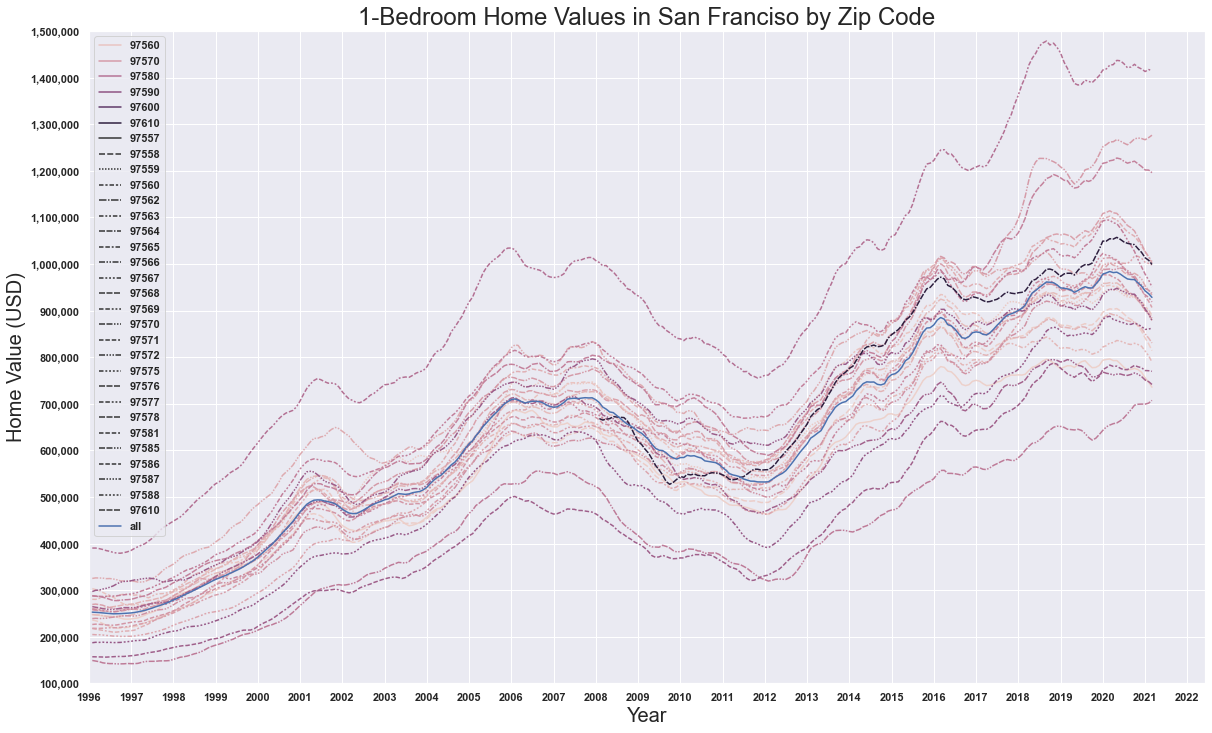

In [250]:
# sns.set_palette('cubehelix', 1) 
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title('1-Bedroom Home Values in San Franciso by Zip Code', size=24)
sns.lineplot(data=df_1, x=df_1.date, y=df_1.value, ax=ax, hue='zipcode', style='zipcode')
sns.lineplot(data=sf_1_all, x=sf_1_all.index, y=sf_1_all.value, ax=ax, color = 'b', label='all')
ax.set_xlabel('Year',  size=20)
ax.set_ylabel('Home Value (USD)', size=20)
ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_yticks(np.linspace(1e5,1.5e6,15))
ax.set_ylim((1e5, 1.5e6))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig('images/1-bdrm_home_values.png')

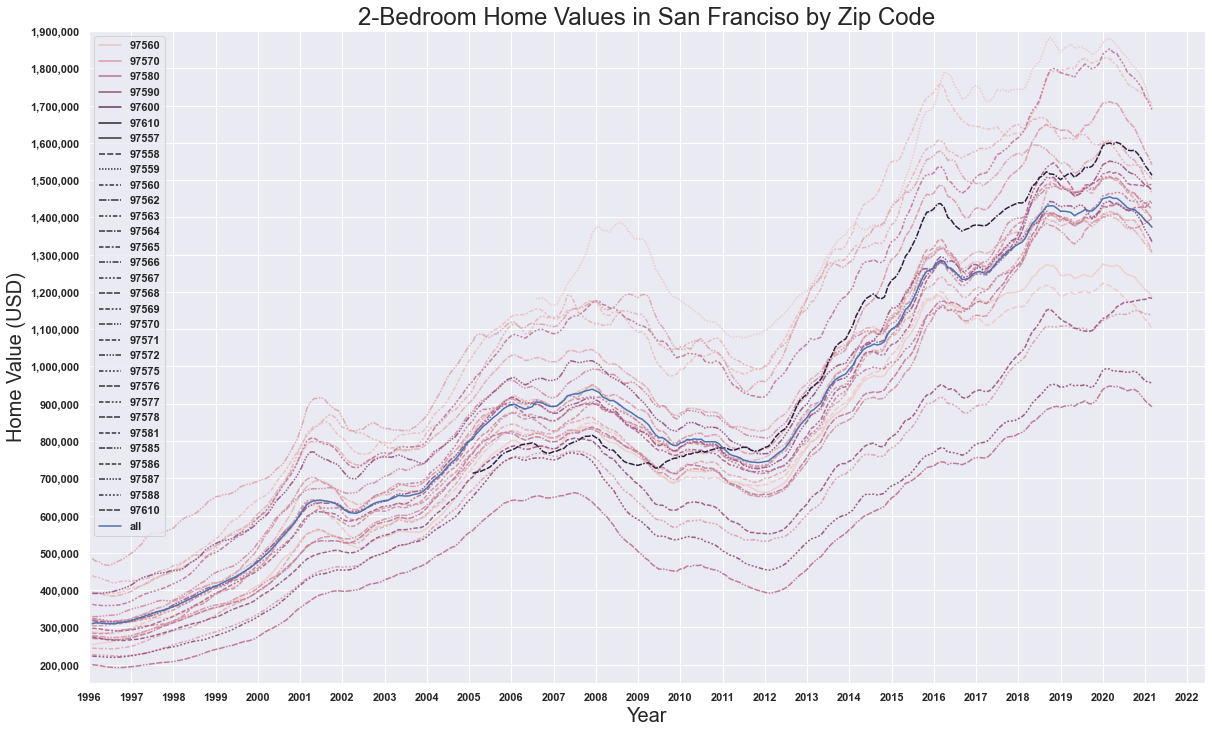

In [249]:
# sns.set_palette('cubehelix', 1) 
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title('2-Bedroom Home Values in San Franciso by Zip Code', size=24)
sns.lineplot(data=df_2, x=df_2.date, y=df_2.value, ax=ax, hue='zipcode', style='zipcode')
sns.lineplot(data=sf_2_all, x=sf_2_all.index, y=sf_2_all.value, ax=ax, color = 'b', label='all')
ax.set_xlabel('Year',  size=20)
ax.set_ylabel('Home Value (USD)', size=20)
ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_yticks(np.linspace(2e5,1.9e6,18))
ax.set_ylim((1.5e5, 1.9e6))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig('images/2_bdrm_home_values.png')

In [168]:
zipcodes = list(set(df_1.zipcode))
# keys = ["1_bdrm_" + zipcode for zipcode in list(map(str, zipcodes))]
keys_1 = ["1_bdrm_" + zipcode for zipcode in map(str, zipcodes)]
keys_2 = ["2_bdrm_" + zipcode for zipcode in map(str, zipcodes)]
sf_1_list = []
sf_2_list = []

for zipcode in zipcodes:
    sf_1_list.append(df_1[df_1.zipcode == zipcode])
    sf_1_list[-1].drop('zipcode', inplace=True, axis=1)
#     sf_1_list[-1].columns = ['date', 'value']
    sf_1_list[-1].date = pd.to_datetime(sf_1_list[-1].date)
    sf_1_list[-1].set_index('date', inplace=True)
    sf_1_list[-1] = sf_1_list[-1].asfreq('M')
    
    sf_2_list.append(df_2[df_2.zipcode == zipcode])
    sf_2_list[-1].drop('zipcode', inplace=True, axis=1)
#     sf_1_list[-1].columns = ['date', 'value']
    sf_2_list[-1].date = pd.to_datetime(sf_2_list[-1].date)
    sf_2_list[-1].set_index('date', inplace=True)
    sf_2_list[-1] = sf_2_list[-1].asfreq('M')

sf_1_dict = dict(zip(keys_1, sf_1_list))
sf_2_dict = dict(zip(keys_2, sf_2_list))

In [177]:
sf_1_dict[keys_1[0]]

,value
date,
1996-01-31,247368.0
1996-02-29,247287.0
1996-03-31,245709.0
1996-04-30,244646.0
1996-05-31,243029.0
1996-06-30,243349.0
1996-07-31,243108.0
1996-08-31,242114.0
1996-09-30,240101.0


## Plot ACF and PACF

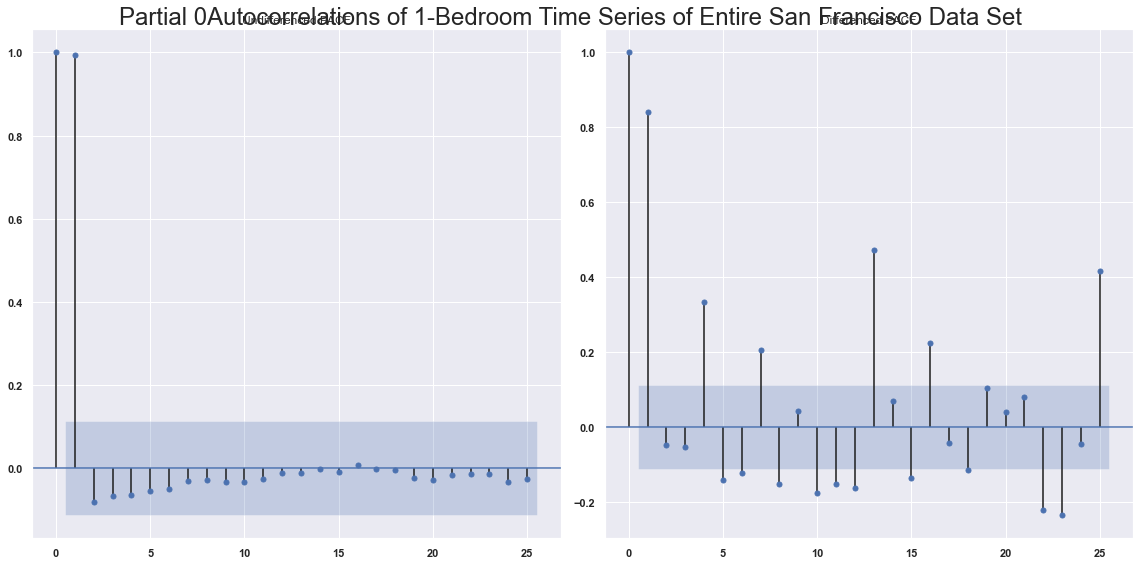

In [258]:
pacf_1_fig, ax = plt.subplots(1, 2, figsize=(16, 8))
pacf_1_fig.suptitle('Partial 0Autocorrelations of 1-Bedroom Time Series of Entire San Francisco Data Set', fontsize=24)
plot_pacf(sf_1_all, ax=ax[0])
ax[0].set_title('Undifferenced PACF')
plot_pacf(sf_1_all.diff().dropna(), ax=ax[1])
ax[1].set_title('Differenced PACF')
pacf_1_fig.tight_layout()
pacf_1_fig.subplots_adjust(top=0.94)
plt.savefig('images/1_bdrm_PACF.png')

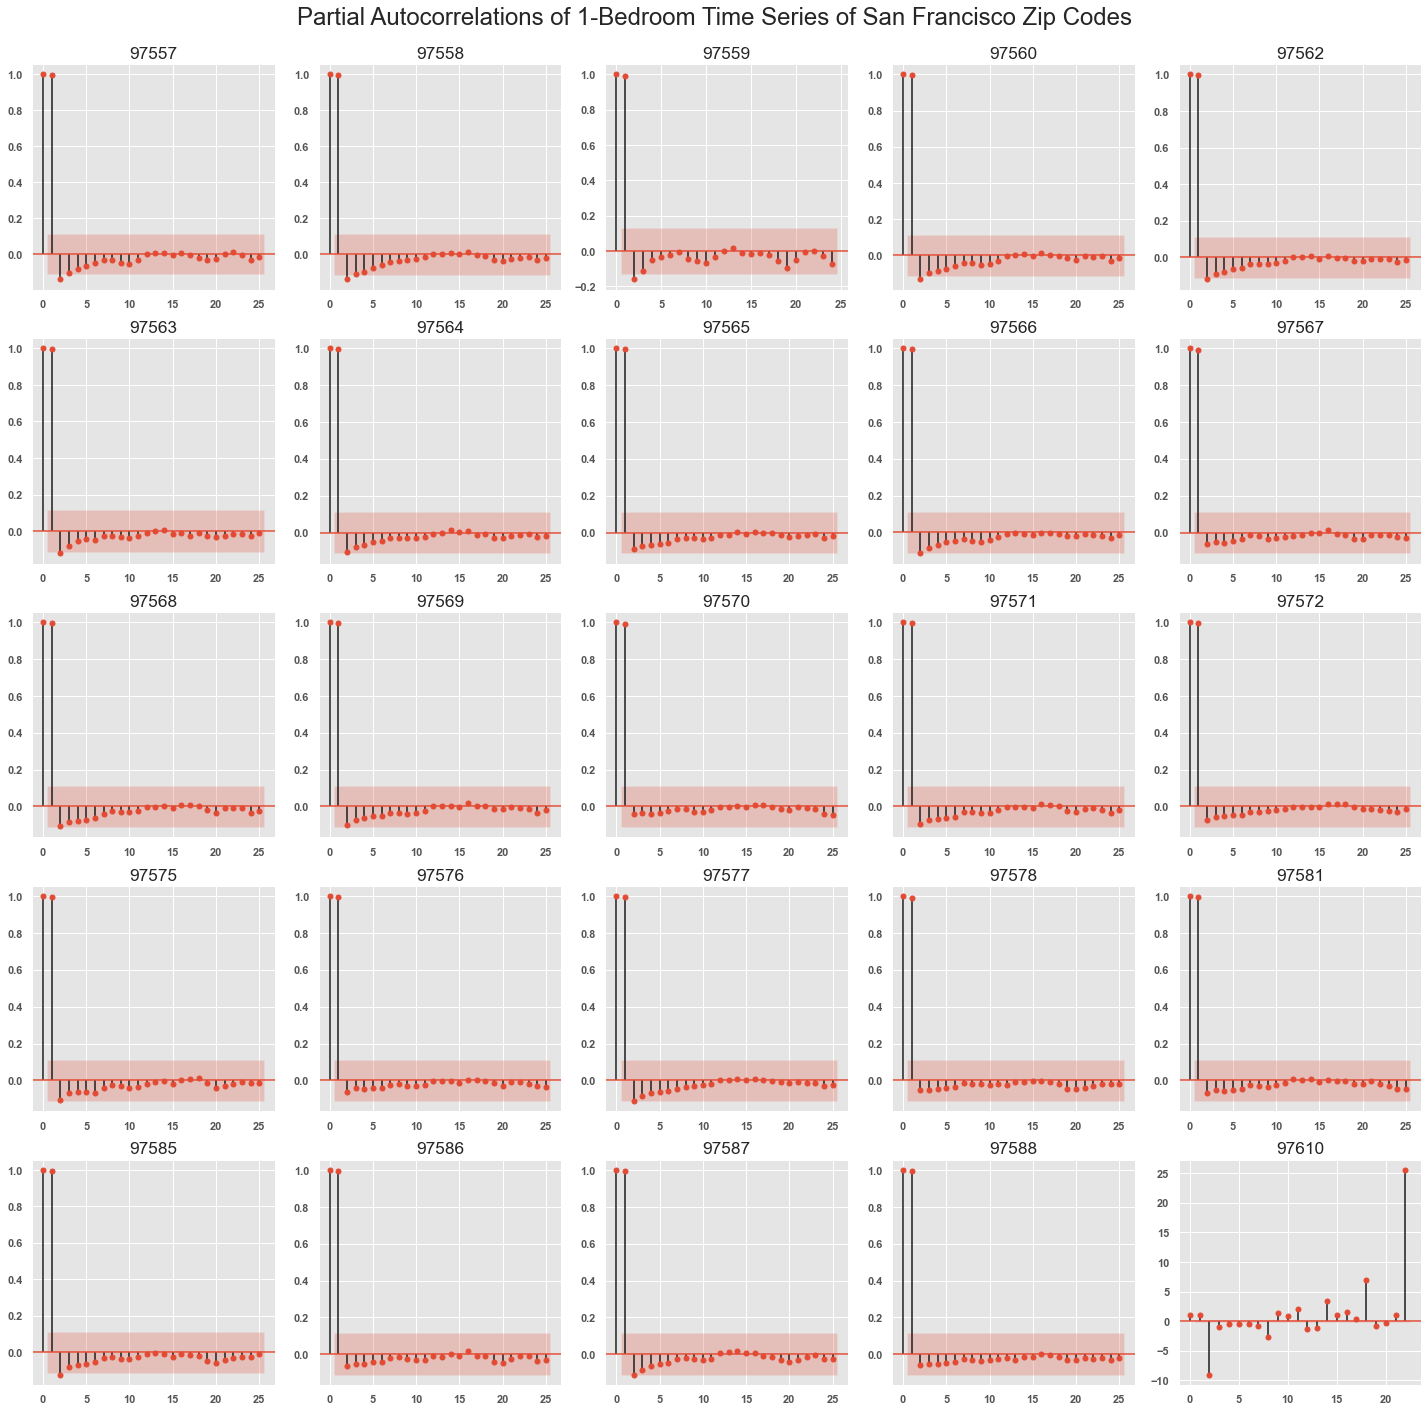

In [214]:
pacf_1_fig, ax = plt.subplots(5, 5, figsize=(20, 20))
pacf_1_fig.suptitle('Partial Autocorrelations of 1-Bedroom Time Series of San Francisco Zip Codes', fontsize=24)
count = 0
for i in range(5):
    for j in range(5):
        plot_pacf(sf_1_dict[keys_1[count]], ax=ax[i][j])
        ax[i][j].set_title(keys_1[count][-5:])
        count+=1
pacf_1_fig.tight_layout()
pacf_1_fig.subplots_adjust(top=0.94)
plt.savefig('images/1_bdrm_PACF.png')

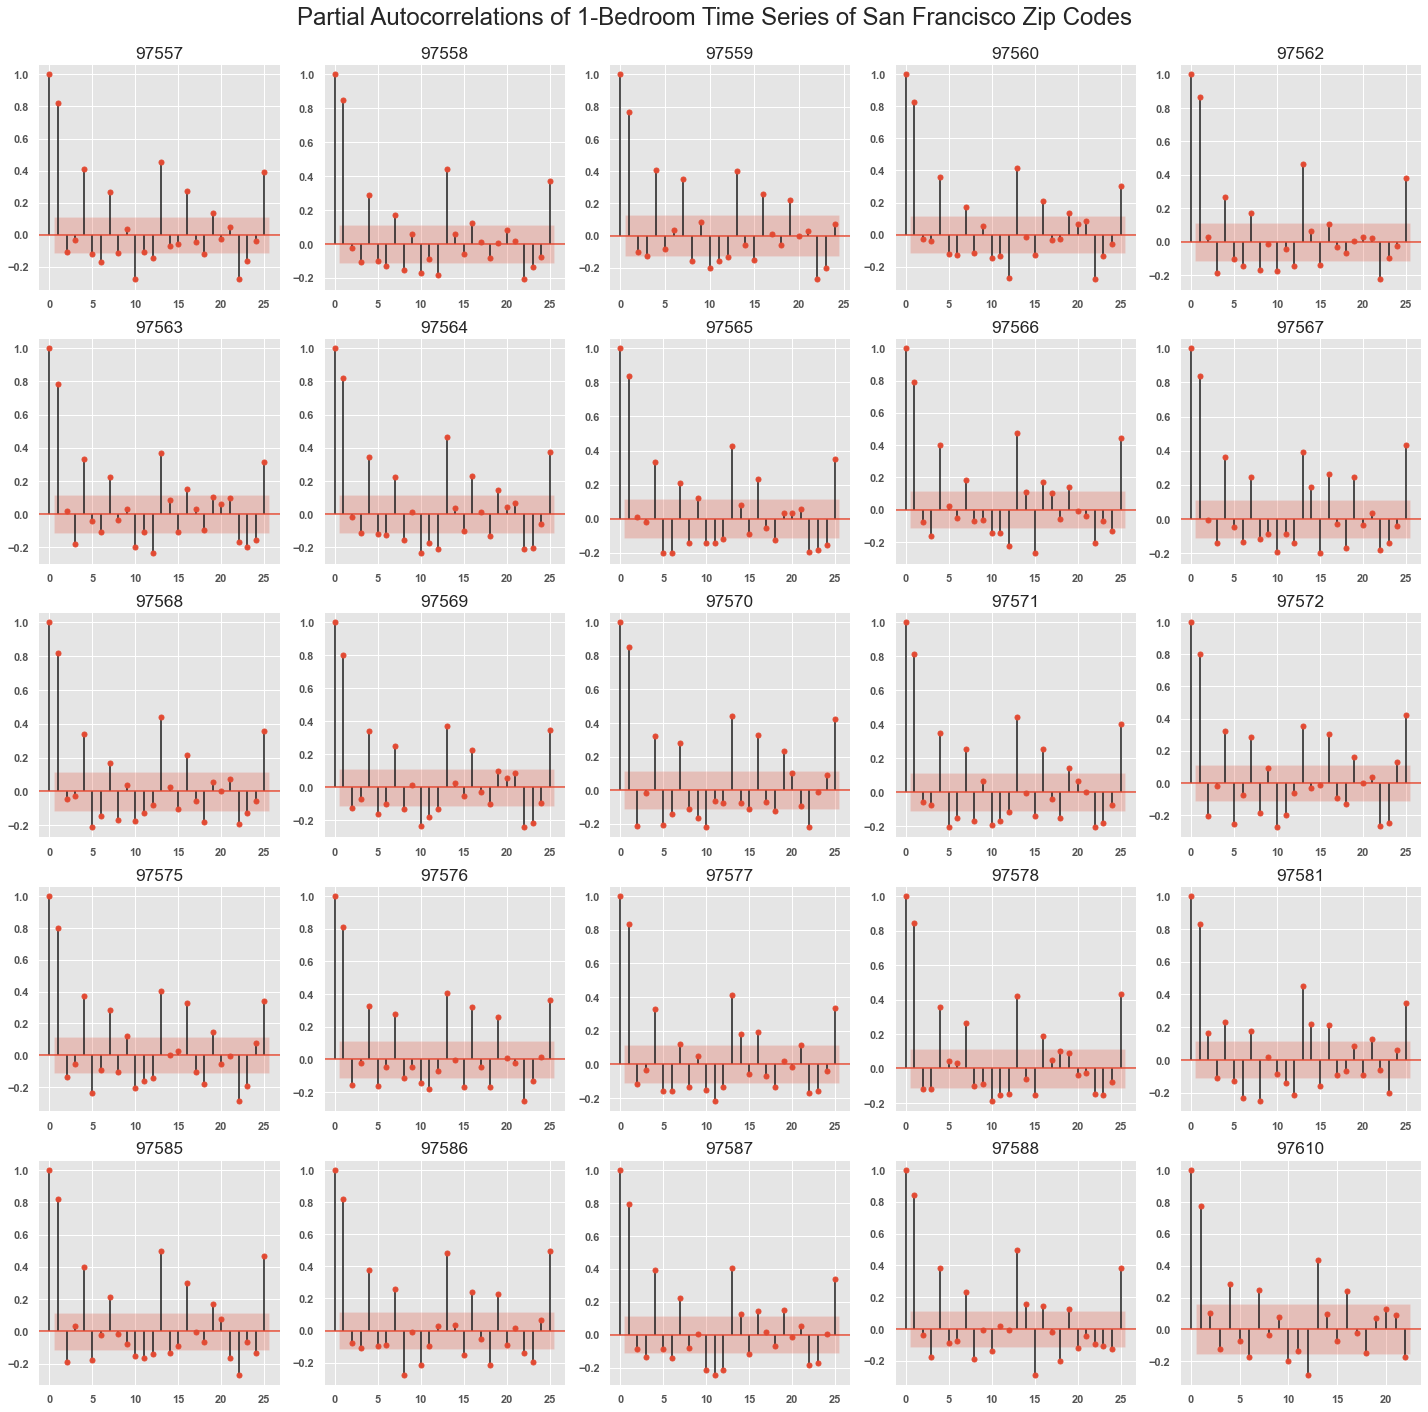

In [213]:
pacf_1_diff_fig, ax = plt.subplots(5, 5, figsize=(20, 20))
pacf_1_diff_fig.suptitle('Partial Autocorrelations of 1-Bedroom Time Series of San Francisco Zip Codes', fontsize=24)
count = 0
for i in range(5):
    for j in range(5):
        plot_pacf(sf_1_dict[keys_1[count]].diff().dropna(), ax=ax[i][j])
        ax[i][j].set_title(keys_1[count][-5:])
        count+=1
pacf_1_diff_fig.tight_layout()
pacf_1_diff_fig.subplots_adjust(top=0.94)
plt.savefig('images/1_bdrm_PACF_diff.png')

Text(0.5, 1.0, '97610')

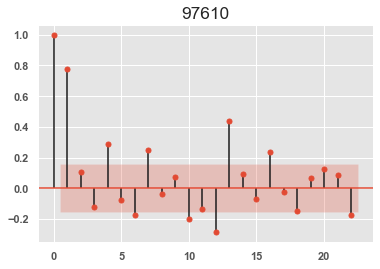

In [211]:
plot_pacf(sf_1_dict[keys_1[-1]].diff().dropna())
plt.title(keys_1[-1][-5:])

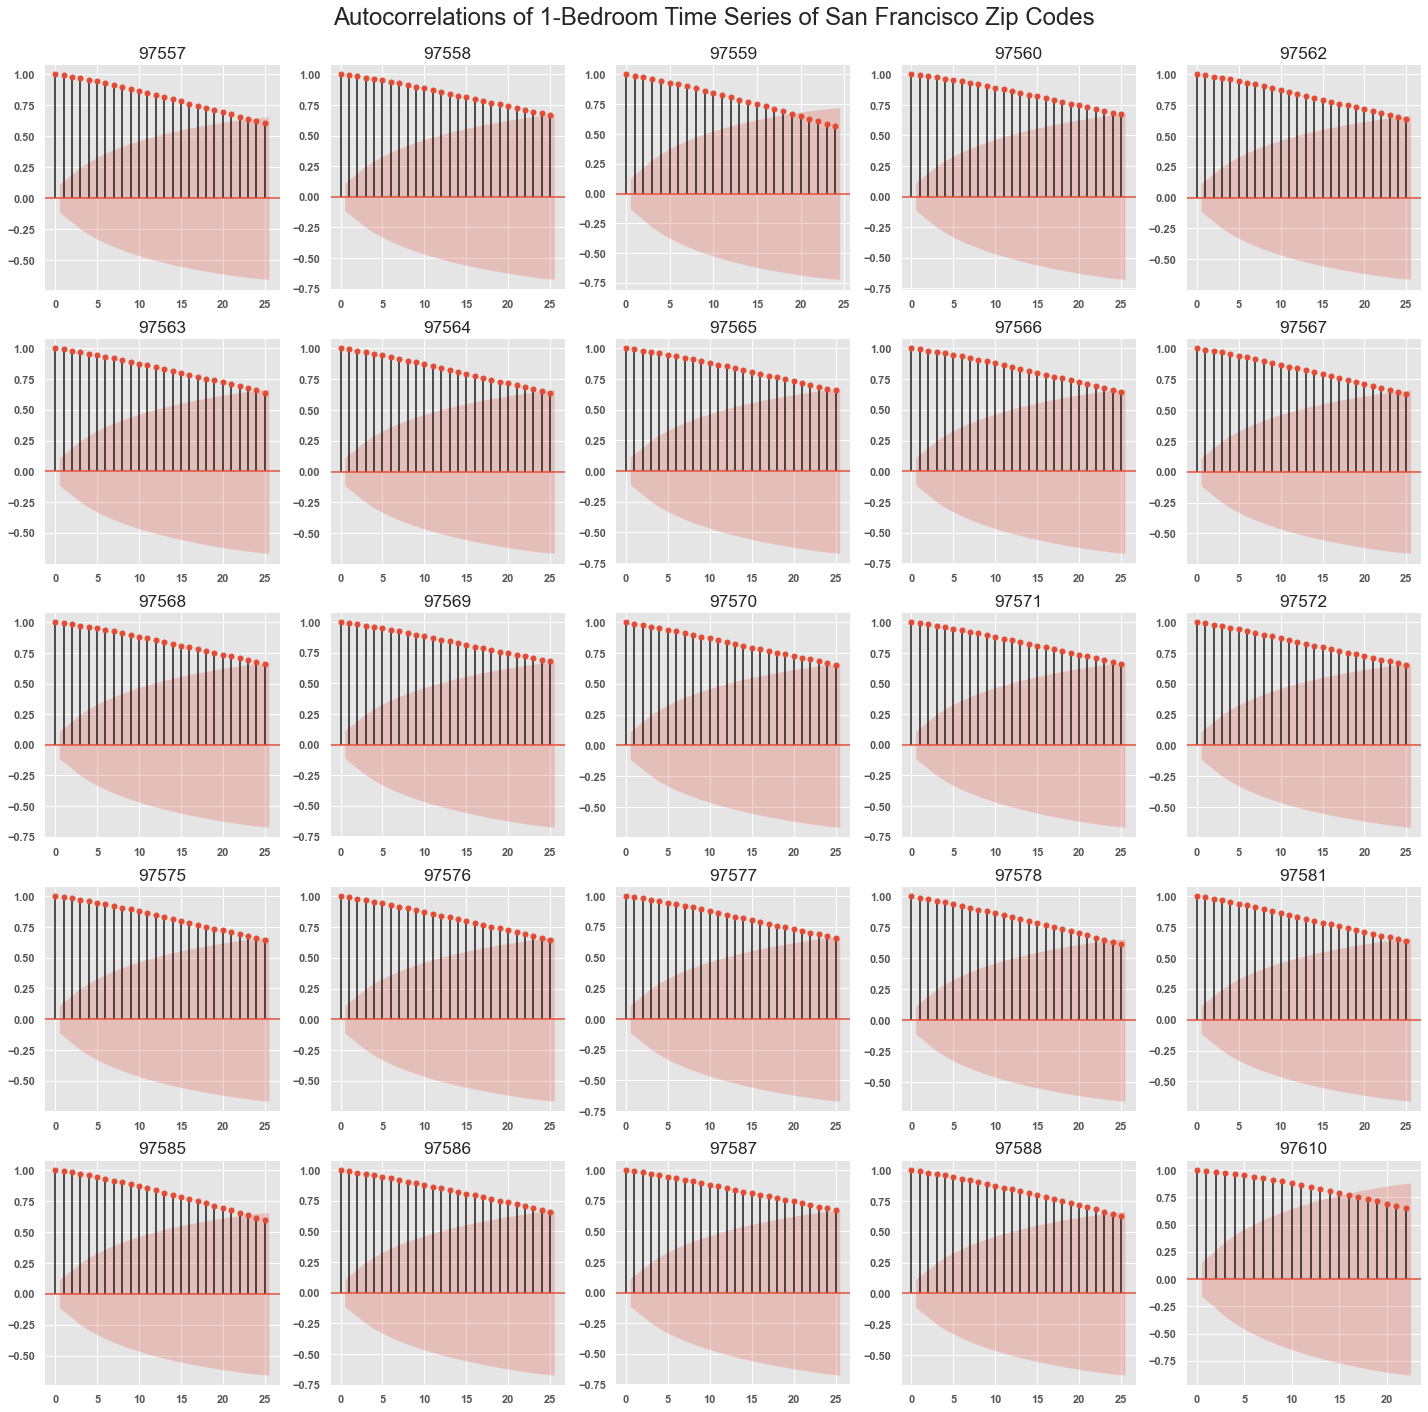

In [215]:
acf_1_fig, ax = plt.subplots(5, 5, figsize=(20, 20))
acf_1_fig.suptitle('Autocorrelations of 1-Bedroom Time Series of San Francisco Zip Codes', fontsize=24)
count = 0
for i in range(5):
    for j in range(5):
        plot_acf(sf_1_dict[keys_1[count]], ax=ax[i][j])
        ax[i][j].set_title(keys_1[count][-5:])
        count+=1
acf_1_fig.tight_layout()
acf_1_fig.subplots_adjust(top=0.94)
plt.savefig('images/1_bdrm_ACF.png')

## Plot seasonal decomposition

### 1-Bedroom

AttributeError: 'Figure' object has no attribute 'set_xlim'

<Figure size 432x288 with 0 Axes>

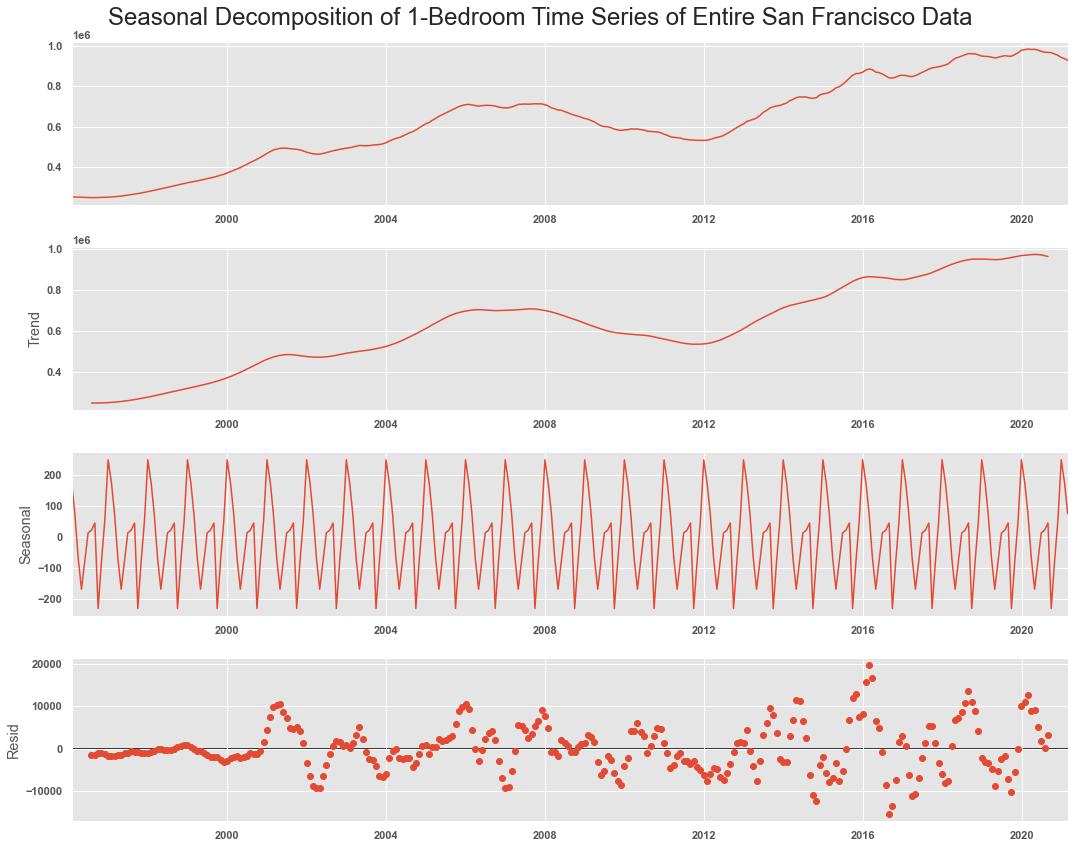

In [236]:
decomp_1_fig, ax = plt.subplots(4, 1, figsize=(20, 20))
decomp_1 = seasonal_decompose(sf_1_all, freq=12)
dc_1_obs = decomp_1.observed
dc_1_seas = decomp_1.seasonal
dc_1_resid = decomp_1.resid
decomp_1_fig = plt.figure()
decomp_1_fig = decomp_1.plot()
decomp_1_fig.set_size_inches(15, 12)
decomp_1_fig.suptitle('Seasonal Decomposition of 1-Bedroom Time Series of Entire San Francisco Data', fontsize=24)
decomp_1_fig.tight_layout()
decomp_1_fig.subplots_adjust(top=0.94)
decomp_1_fig.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
decomp_1_fig.xaxis.set_major_locator(mdates.YearLocator())
decomp_1_fig.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.savefig('images/1_bdrm_seasonal_decomp.png')

In [ ]:
sf_cheese_df_97564.variable.describe()

# ARIMA Modeling

## Train test split

In [171]:
cutoff = round(len(sf_1_dict[list(sf_1_dict.keys())[0]])*.8)

sf_1_train_dict_list = [sf_1_dict[i][:cutoff] for i in list(sf_1_dict.keys())]
sf_1_train_dict = dict(zip(list(sf_1_dict.keys()), sf_1_train_dict_list))

sf_2_train_dict_list = [sf_2_dict[i][:cutoff] for i in list(sf_2_dict.keys())]
sf_2_train_dict = dict(zip(list(sf_2_dict.keys()), sf_2_train_dict_list))

## Manual search of different paramters

In [28]:
p = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 2, 12)
SARIMAX: (0, 1, 0) x (1, 1, 0, 12)
SARIMAX: (0, 1, 0) x (1, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 1, 2, 12)
SARIMAX: (0, 1, 0) x (2, 1, 0, 12)
SARIMAX: (0, 1, 0) x (2, 1, 1, 12)
SARIMAX: (0, 1, 0) x (2, 1, 2, 12)
SARIMAX: (0, 1, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 1) x (1, 1, 0, 12)
SARIMAX: (0, 1, 1) x (1, 1, 1, 12)
SARIMAX: (0, 1, 1) x (1, 1, 2, 12)
SARIMAX: (0, 1, 1) x (2, 1, 0, 12)
SARIMAX: (0, 1, 1) x (2, 1, 1, 12)
SARIMAX: (0, 1, 1) x (2, 1, 2, 12)
SARIMAX: (0, 1, 2) x (0, 1, 0, 12)
SARIMAX: (0, 1, 2) x (0, 1, 1, 12)
SARIMAX: (0, 1, 2) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
SARIMAX: (0, 1, 2) x (1, 1, 2, 12)
SARIMAX: (0, 1, 2) x (2, 1, 0, 12)
SARIMAX: (0, 1, 2) x (2, 1, 1, 12)
SARIMAX: (0, 1, 2) x (2, 1, 2, 12)
SARIMAX: (1, 1, 0) 

In [37]:
zipcodes = []
param_list = []
param_seasonal_list = []
aic_list = []


# for train in [sf_train_dict[i] for i in list(sf_train_dict.keys())]:
for zipcode, train in sf_train_dict.items():
    for param in pdq:
        for param_seasonal in seasonal_pdq:
#             try:
                mod=SARIMAX(train,
                             order=param,
                             seasonal_order=param_seasonal,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
                zipcodes.append(zipcode[-5:])
                param_list.append(param)
                param_seasonal_list.append(param_seasonal)
                aic_list.append(mod.fit().aic)
                print(aic_list[-1])
#             except: 
#                 print('Oops!')
#                 continue

4713.169841856549
4439.441350731824
4188.208476997037
4444.816949032707
4425.756903072921
4185.257541793078
4201.613117840266
4203.696469140751
4180.583762961309
4596.978528862114
4323.424455745766
4066.9672760107264
4360.485195601678
4313.266116251336
4068.732107629222
4110.2810604837305
4111.88138064795
4068.3328704529677
4502.37303269031
4209.500427791174
3939.0246321020545
4280.036662485937
4206.030595523776
3937.852050380966
4009.2858249757014
4008.570334286458
3936.1684349834736
4495.202125140217
4222.705780074495
3914.382656357502
4180.948950615
4181.357557507601
3936.6593552570826
3877.8334969508287
3922.3725886437405
3924.0785531496736
4478.480266252882
4206.004471034783
3925.30773938502
4183.968646070221
4165.682647840588
3920.418669866226
3924.079467439251
3925.566267554787
3908.0276914882656
4449.044061415082
4170.913223463095
3894.0185948390963
4177.051736286618
4121.157776249935
3891.2394802405533
3915.4601794682085
3916.899585960592
3878.8432780645835
4478.461275900625
4

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3919.9905320028797
3899.9677393711318


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3901.477013836464


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4806.21606701814
4449.475786974522
4167.752916020935
3884.320439507862
4156.945752328695
4134.204571980852
3883.090402160645
3892.970807060865
3894.4266287105447
3872.988776647644
4745.796631040457
4466.064010066452
4210.159914615269
4469.481027986643
4449.930497714347
4208.35360237723
4228.0055289241745
4228.494957544239
4207.555217252114
4632.414463207935
4355.0878472678505
4097.354696045167
4403.0439206401325
4343.145875004808
4098.485593216496
4139.161972034226
4140.757977797349
4098.600779249387
4536.764075776043
4247.88303379251
3981.1062500573557
4320.460919985503
4241.390999713238
3979.294189211759
4046.164328732718
4047.0550437369952
3977.6672435679493
4529.6047015026725
4251.647314641554
3970.8872423601006
4207.586939562134
4207.784904369701
3963.4439455995553
3950.5514072616807
3951.9654390555916
3953.5735806718553
4512.046160268268
4233.832725541082
3952.870673336085
4210.475702700618
4191.379740274277
3946.287829066466
3953.4051724054075
3954.827455013913
3936.780830100581

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3887.0042687276323
3929.2445215515304
3930.702352667745
4482.516402283083
4198.91436236615
3916.118217368675
4183.307685218155
4161.888595606251
3912.6587019126264
3922.8284450805268
3924.1298438304366
3903.409933458147
5062.971700555004
4761.407883212114
4488.524101413893
4775.191316208917
4748.361169807275
4485.742020185561
4500.893883339772
4502.631103569691
4474.409303386463
4951.016365017567
4652.457257268767
4369.469561354153
4710.778967535001
4641.777341437544
4369.973420855702
4416.950653492835
4418.932453394804
4370.583307589329
4875.269339244409
4543.883023199518
4259.734244549443
4624.626522107237
4534.85597762512
4257.627119025701
4320.119765794356
4321.996257199933
4249.018620930611
4883.542927415584
4588.8776857080065
4290.31461816935
4547.81693580047
4546.966931172062
4279.189451171918
4260.288807256862
4262.0716122338345
4264.045238716961
4863.551459063854
4569.653815457143
4271.015230681097
4549.834588457185
4528.261818845746
4260.346892307886
4262.098733574096
4263.88

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4353.783109404569
4063.974191374951
4311.075808872143
4311.30720945428
4056.9880238326023
3999.099857189406
4045.4025739012814
4047.4002271899553
4617.108733967214
4334.558302937268
4045.438942028858
4313.73668553463
4294.058824349901
4039.150767254852
4047.4229194376826
4048.2525746660117
4030.0497660290075
4591.281210338165
4306.556307538423
4021.3280957987163
4310.438119012602
4268.855765829483
4014.799204769566
4042.6540869956866
4043.4372330368237
4004.6594224586
4616.239441855327
4354.375656107457
4064.4745142735687
4292.616984927823
4292.752968052045
4058.0648923184053
4025.5709630921547
4026.2517750843285
4028.2517243759617
4636.550648101107
4328.537085726175
4077.8188867305958
4290.1994634776165
4290.298863678578
4032.859151704824
4025.6562907917623
4022.7513727936157
4024.749105938048
4587.168193982927
4299.044462038406
4010.6671849078875
4287.824819430214
4263.683936732683
4005.7326824187458
4017.9065753470654
4018.5384281477336
3997.2525138228652
4858.27712758851
4574.34824

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4094.887102524064
4370.956719650866
4368.5145210871215
4092.3488032383752
4076.829474249181
4078.2740593685644
4079.07447601208
4638.19188689409
4352.2994599726535
4063.6596999114795
4343.3145624633935
4323.636227772693
4061.6954868038765
4071.957104430505
4073.4172626385525
4052.195568600171
4792.573244554145
4514.853082137264
4252.957089408645
4521.624433320418
4501.698351181615
4252.34108134061
4271.375972482252
4271.86542905719
4249.007764399439
4687.51384635686
4411.996522845768
4146.340435508045
4463.287378859969
4400.2175005094805
4147.907287350618
4191.91856553862
4167.980195824519
4147.792311981061
4605.640726922742
4318.756207963785
4046.7574002506267
4391.130623668145
4309.899039228776
4048.8497635113713
4109.012310021584
4110.656600397621
4046.2330048616204
4605.600652339213
4331.955949771458
4049.0710118606685
4293.871930834694
4295.061021283398
4043.8307697378063
4027.8349742028877
4029.118597836282
4030.1341986544994
4587.507272991632
4316.459271612763
4030.8245836732594

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4335.61474376719
4050.2405556748718
4276.248831079334
4277.376164007579
4045.335661980302
3973.925388214766
4010.4887906711206
4011.4258048798056
4610.526765606219
4312.5680483544365
4070.3767368801796
4275.283582975771
4276.239119145583
4023.456365776877
4008.334461520858
4009.596754688544
4010.557061911725
4563.371497846244
4288.688221931054
4003.7260887884872
4274.721124606587
4255.229858498427
4000.5984037892877
4007.011755455653
4008.2349786747072
3988.2064544619006
4863.829175207386
4576.305776622001
4323.473521930962
4584.02626759946
4562.829317249896
4317.437414732647
4333.118893644396
4335.4033319875725
4313.188763112122
4762.73135908521
4476.885345278455
4213.56661155223
4514.84434134347
4464.827713662534
4215.044655814656
4258.236153970689
4260.0083880926
4213.482876421947
4678.672141402881
4371.680444096877
4112.4147585199
4460.881739281521
4375.131478313544
4114.048818600433
4178.532941001354
4180.202760640879
4114.487674980085
4701.736975671718
4413.8690303746525
4129.476

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4052.27976322334
4095.684237324227
4097.56090453579
4655.777189402555
4365.262954772334
4081.7063492716907
4366.497053717594
4342.349143478636
4079.726904992631
4086.295562099116
4086.969465772518
4066.843229085038
4940.490942468561
4649.588768364782
4374.919163841898
4655.037160400163
4632.130361235817
4370.124122193468
4382.91928224374
4384.544722818802
4355.37259604964
4823.109728221381
4532.810994019972
4258.722131438864
4587.128374559945
4521.294872246542
4260.381877231246
4308.106998553747
4309.713688967822
4257.575658320046
4734.030497361462
4438.325567866683
4160.445798083943
4512.806525858663
4430.576992087406
4160.012531297058
4222.535385534997
4224.662854347171
4157.046979570455
4726.212344814385


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4451.110461735038
4157.789340721059
4411.169136535346
4412.30609372066
4153.479992450651
4138.767980641545
4139.877717644442
4141.816171274352
4707.928615455054
4433.301214311032
4140.151422803303
4413.574139568103
4394.632750291441
4136.086030929662
4141.450739986908
4142.568157176936
4124.780403096356
4685.253237710751
4409.345442138163
4118.375307001885
4413.179892622599
4372.681832751407
4114.460084156344
4140.585647943566
4141.692083509913
4103.904230159663
4707.5936578724995
4453.016956541927
4159.758107852482
4392.744443123589
4394.029962245631
4155.466830911765
4121.081359519173
4122.195906103624
4124.131640913928
4767.060859485229
4434.3012314110565
4139.457470946903
4393.929871983129
4395.729496850827


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4135.782505067969
4121.835556060475
4122.936942912608
4124.85276360327
4687.354395691824
4406.253727882579
4113.84986702764
4392.877026587219
4372.494961618831
4110.313049586444
4119.448346886046
4120.594777221902
4101.634811914191
4703.827915738384
4442.941633223161
4208.424770278588
4455.874295956237
4437.586795047422
4204.203940115528
4214.982706364464
4217.258298316846
4200.382868057655
4600.145071236664
4333.133837639523
4083.778180709398
4382.810326676083
4326.586497365639
4085.771042913926
4127.027682118096
4128.748588793329
4085.963298024339
4516.681503065041
4232.232748949387
3966.38914094305
4304.50958586115
4230.002640951563
3962.441909836431
4035.7750833438613
4035.3848070600834
3959.934637977936
4526.6358470492505
4255.841555210188
3979.003333284522
4208.751515407739
4222.477220295843
3975.565266392329
3963.6803016318163
3964.4460604560772
3966.4413159854494
4509.218273449884
4237.9394324127425
3935.741744002944
4224.920490896746
4205.235165310207
3957.1952306224384
3966.0

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3931.484164829151
3944.6057279634797
4482.168073618832
4205.814847872495
3929.4686308270734
4202.422010756009
4179.678317005551
3928.127798266123
3940.557709921416
3941.303537046363
3920.437401416055
4986.797140416074
4688.248824704806
4426.455780348632
4691.165527037119
4670.655761874785
4417.470123001752
4437.635840059267
4437.521895277273
4418.352861074711
4869.296177812562
4572.750333683363
4301.137059225686
4621.737608625785
4558.575563197499
4302.519884518489
4346.03804494293
4347.556426354167
4302.694578893153
4785.650124476446
4474.8835312081665
4193.242529388776
4554.039240800668
4462.573993147165
4193.48893513497
4257.194061532051
4258.864705775381
4194.941739239758
4815.818590789833
4521.253598406049
4229.772834559246
4491.15406252816
4490.657646363202
4227.402027929974
4218.278788886597
4218.425311514261
4220.395224651145
4793.998608295591
4501.193894239997
4210.655323012223
4491.658950885011
4470.445895297628
4208.3585722043745
4219.559024042079
4219.794173673065
4201.6527

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4703.33411455286
4399.099367214676
4116.50900530057
4477.062560521719
4385.429684637938
4117.588891825299
4183.257907790951
4184.961643025528
4118.164195660256
4722.773359274331
4435.6068548575695
4145.13692254299
4396.933811145766
4396.880718179627
4139.3503559601095
4127.970312735155
4128.824866149292
4130.774132500074
4704.882780901817
4418.233749009835
4128.025768335414
4399.699930414974
4379.99195575682
4122.550159114745
4131.147969676889
4132.010527331586
4114.226612710605
4676.445447806986
4385.79561578559
4098.478170765744
4394.122988310921
4353.2218588945425
4094.5299319068163
4124.174905719445
4124.935972420448
4086.3615789027012
4704.793446390882
4437.712273779165
4147.309426631283
4379.114757146531
4379.208439504211
4141.594824572165
4110.49687932937
4111.336517552814
4113.278456993043
4759.599246389304
4419.440453777499
4125.557784433455
4404.509071393226
4379.522193945843
4120.3851357736285
4109.411433384463
4110.620041603815
4112.539401193908
4677.761403049335
4383.61474

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4089.0690290912257
4074.511130020496
4075.2328843996142
4077.5756431339228
4640.388589545026
4358.114829721542
4069.6037889796808
4344.215341202007
4325.018873083231
4066.1198106350057
4074.0115682414234
4075.140939485381
4055.0174262093155
4799.152111457959
4520.088725277347
4267.81157700168
4523.36168705492
4502.726866180041
4257.608992925788
4263.570946385938
4265.710599415624
4245.099755533169
4686.044905668713
4406.166892009215
4139.881373748423
4458.313802202691
4393.263521116451
4140.916204842543
4184.931871563389
4186.900629923632
4141.576943724278
4599.908207914937
4306.362181823562
4032.9745198567452
4382.228353383582
4298.236689320207
4033.111867766252
4100.517780589029
4090.5145147645853
4033.037624863996
4600.048310357874
4325.462448214281
4041.797124770729
4291.132750956292
4291.095097396818
4037.3278456727735
4018.8492760660147
3980.21647560041
4021.966472579117
4582.873533843241
4308.542111693041
4025.007060032997
4293.8526355888425
4274.3276655219015
4020.8976924187446

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4020.478464343692
4273.348910447773
4273.20402956201


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4019.0349459976933
4001.1446511261975
3999.9561432495857


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4003.4063207549107
4555.686814508266
4277.1378298752425
3993.481285129098
4271.065168273082
4248.82360539436
3991.3213937338337
3997.5785630170035
3998.7123417323533
3977.307977784125
5017.242888206059
4716.791278560679
4448.620568909135
4706.10017080451
4687.009561533429
4433.65783638233
4452.920456502323
4453.9671186813175
4435.446245281764
4904.634033666716
4609.808027264132
4328.651943013523
4657.701126693719
4589.753784968529
4328.283482889638
4372.144892181257
4373.65224878072
4328.66694900077
4826.941913392646
4519.406230830113
4231.8241402116955
4598.333934491611
4496.764609594193
4228.548969878747
4293.056334456282
4294.98828121964
4230.423408423715
4846.862663539387
4554.189889811093
4254.177561953984
4506.3337920509
4507.564997811807
4245.961530702829
4237.666396385952
4238.602521884815
4240.297615728077
4826.723575810306
4535.787380057389
4236.1948345599785
4508.8301431909
4489.737622861445
4227.890202572517
4240.319875091802
4241.264901229829
4222.364607089712
4794.7510747

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3960.648043315773
3987.9818957137513
3989.75069010066
4532.233975097497
4257.987468495769
3980.1400947181155
4263.503216250057
4239.6248941480635
3980.6773256380484
3985.2421378313725
3986.0375167775614
3965.6342420678166
4903.305301135379
4609.046551617466
4332.351473704673
4608.182587618985
4586.079221456326
4326.607537502817
4345.033689668302
4345.295199256986
4320.916706453956
4786.672627260535
4496.088370019528
4224.070200041693
4549.746319786747
4483.584995055361
4225.447401387375
4270.379671793888
4271.935024209643
4224.320572611422
4704.22542192851
4409.290305137893
4129.266419674808
4486.547216640852
4397.402242239867
4129.3052595284025
4191.870302963645
4193.689206619365
4128.476001671648
4711.7599563064505
4429.060030919776
4143.889528377811
4395.168706100138
4395.281982316454
4139.789963031914
4125.229197808903
4126.739053154804
4127.3731985865925
4692.76484608274
4411.117041120322
4126.354667958505
4397.480029567672
4377.948781233914
4122.429428216858
4094.38676487265
4129

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3885.842428365955
3909.7537123179
3911.6495809984967
4443.894369874615
4170.565473597743
3894.2219117498803
4169.139273666067
4144.655315739151
3893.6281257761693
3907.7366093602777
3908.5814908044845
3887.8125917230245
3949.180279223603
3663.9336659310056
3391.155043167525
3650.8188769801145
3632.2216739067308
3371.239528548075
3382.542340045386
3384.0764237575468
3365.899687999172
3871.153658770504
3587.0314327199635
3295.2702473005183
3639.361134260832
3567.8232893503255
3293.6161827154483
3341.982895502483
3343.9143378084436
3292.778099162473
3818.9658391960324
3515.0177301743743
3228.1373669498435
3590.181880199609
3499.9145017292676
3226.4701015046076
3289.5882967532007
3291.5047988730184
3223.0548172763793
3839.6745842546916
3559.9891184439402
3266.8284561300834
3528.351468070657
3527.2941944939835
3259.5374202476405
3240.208171627314
3241.594303502784
3243.289879438767
3821.3393083540814
3542.0613800062656
3248.8964766584886
3531.2386336825257
3509.8943481317256
3241.7825253378

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3250.745127139809
3543.1892038977003


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3513.6130851538983


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3416.8941258377963
3223.0451880807586


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3255.412962965659


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4018.952350180609
3801.7635038918243
3511.5955962499256
3221.3060761393535
3506.4650503503753
3483.8250680373058
3215.7489714312187
3215.363732678764
3216.8112027767943
3195.2848415743983


In [34]:
for zipcode, train in sf_train_dict.items():
    print(zipcode[-5:]);

97557
97558
97559
97560
97562
97563
97564
97565
97566
97567
97568
97569
97570
97571
97572
97575
97576
97577
97578
97581
97585
97586
97587
97588
97610


In [38]:
zipcodes;

['97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97557',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',
 '97558',


In [39]:
# intialise data of lists.
data = {'zipcodes': zipcodes,
        'param': param_list,
        'param_seasonal': param_seasonal_list,
        'aic': aic_list}

# Create DataFrame
sarimax_details_df = pd.DataFrame(data)

# Print the output.
sarimax_details_df.shape

(2025, 4)

In [40]:
sarimax_details_df

,zipcodes,param,param_seasonal,aic
0,97557,"(0, 1, 0)","(0, 1, 0, 12)",4713.169842
1,97557,"(0, 1, 0)","(0, 1, 1, 12)",4439.441351
2,97557,"(0, 1, 0)","(0, 1, 2, 12)",4188.208477
3,97557,"(0, 1, 0)","(1, 1, 0, 12)",4444.816949
4,97557,"(0, 1, 0)","(1, 1, 1, 12)",4425.756903
...,...,...,...,...
2020,97610,"(2, 1, 2)","(1, 1, 1, 12)",3483.825068
2021,97610,"(2, 1, 2)","(1, 1, 2, 12)",3215.748971
2022,97610,"(2, 1, 2)","(2, 1, 0, 12)",3215.363733
2023,97610,"(2, 1, 2)","(2, 1, 1, 12)",3216.811203


In [ ]:
sarimax_details_df

# Step 6: Interpreting Results